In [ ]:
#to aquire full access to the data, connect the google drive folder to this Notebook
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Inference Ordner aufräumen

Die gespeicherten Ergebnisse

# Berechnung des Vorhersagefehlers

Die messungen der Verhergesagten Maske werden hier mit denen der ground_truth Maske verglichen.

In [ ]:
from pathlib import Path
import re
import math
import numpy as np
import pandas as pd
from scipy import stats

# Pfade
base_dir = Path("/content/drive/MyDrive/Colab Notebooks/Bachelor/Plots/Plots_Von_05_09/Point/inference")
pred_dir = base_dir / "thickness_pred"
gt_dir   = base_dir / "thickness_gt"

# ---------- Helfer ----------

def has_header(csv_path):
    """Erkennt simpel, ob die erste Zeile eher Header ist."""
    with open(csv_path, 'r', encoding='utf-8', errors='ignore') as f:
        first = f.readline()
    # Wenn Buchstaben in der ersten Zeile stecken, werten wir das als Header
    return bool(re.search(r'[A-Za-zÄÖÜäöü]', first))

def read_thickness_csv(csv_path):
    """Liest eine 2-Spalten-CSV: [spaltenindex, dicke_pixel]. Robust gegen Header und Dezimalkomma."""
    if has_header(csv_path):
        df = pd.read_csv(csv_path)
        # versuche die wahrscheinlichsten Spaltennamen
        cols = list(df.columns)
        if len(cols) < 2:
            # Fallback: ohne Header lesen
            df = pd.read_csv(csv_path, header=None, names=["spaltenindex", "dicke_pixel"])
        else:
            # mappe möglichst auf Standardnamen
            mapping = {}
            # erstbeste zwei Spalten nehmen, aber sinnvoll benennen
            mapping[cols[0]] = "spaltenindex"
            mapping[cols[1]] = "dicke_pixel"
            df = df.rename(columns=mapping)[["spaltenindex", "dicke_pixel"]]
    else:
        df = pd.read_csv(csv_path, header=None, names=["spaltenindex", "dicke_pixel"])

    # Dezimalkomma abfangen und auf float casten
    for c in ["spaltenindex", "dicke_pixel"]:
        ser = df[c].astype(str).str.replace(',', '.', regex=False)
        df[c] = pd.to_numeric(ser, errors='coerce')

    # sortieren, Duplikate im Index vermeiden
    df = df.drop_duplicates(subset=["spaltenindex"]).sort_values("spaltenindex").reset_index(drop=True)
    return df

def clean_stem(p: Path):
    """Entfernt trailing _pred oder _gt aus dem Dateinamenstamm."""
    stem = p.stem  # ohne .csv
    stem = re.sub(r'_(pred|gt)$', '', stem, flags=re.IGNORECASE)
    return stem

def compute_metrics(errors: np.ndarray, total_cols: int):
    """
    Gibt Kennwerte als Dict zurück.
    errors: 1D-Array der validen Fehler e(j) = d_pred - d_ref
    total_cols: Gesamtzahl der Spalten (vor Filter), für Abdeckung
    """
    W = int(np.sum(np.isfinite(errors)))
    if W == 0:
        return dict(W=0, total_columns=int(total_cols), coverage=np.nan,
                    MAE=np.nan, Bias=np.nan, Std=np.nan,
                    CI95_lower=np.nan, CI95_upper=np.nan,
                    MaxAbsError=np.nan)

    e = errors[np.isfinite(errors)]
    mae = float(np.mean(np.abs(e)))
    bias = float(np.mean(e))
    std = float(np.std(e, ddof=1)) if W > 1 else np.nan

    if W > 1 and np.isfinite(std):
        tcrit = stats.t.ppf(0.975, df=W-1)
        half_width = tcrit * std / math.sqrt(W)
        ci_lo = bias - half_width
        ci_hi = bias + half_width
    else:
        ci_lo = np.nan
        ci_hi = np.nan

    max_abs = float(np.max(np.abs(e)))
    coverage = float(W / total_cols) if total_cols > 0 else np.nan

    return dict(W=W, total_columns=int(total_cols), coverage=coverage,
                MAE=mae, Bias=bias, Std=std,
                CI95_lower=ci_lo, CI95_upper=ci_hi,
                MaxAbsError=max_abs)

# ---------- Dateien paaren ----------

pred_files = list(pred_dir.glob("*.csv"))
gt_files   = list(gt_dir.glob("*.csv"))

pred_map = {clean_stem(p): p for p in pred_files}
gt_map   = {clean_stem(p): p for p in gt_files}

common_stems = sorted(set(pred_map.keys()) & set(gt_map.keys()))
missing_pred = sorted(set(gt_map.keys()) - set(pred_map.keys()))
missing_gt   = sorted(set(pred_map.keys()) - set(gt_map.keys()))

if missing_pred:
    print("Warnung: Es fehlen _pred Dateien für:", missing_pred)
if missing_gt:
    print("Warnung: Es fehlen _gt Dateien für:", missing_gt)

# ---------- Metriken je Paar und gesamt ----------

rows = []
all_errors = []

for stem in common_stems:
    df_pred = read_thickness_csv(pred_map[stem]).rename(columns={"dicke_pixel": "d_pred"})
    df_gt   = read_thickness_csv(gt_map[stem]).rename(columns={"dicke_pixel": "d_ref"})

    # Outer-Join auf Spaltenindex, um Gesamtzahl der Spalten zu bestimmen
    merged = pd.merge(df_pred[["spaltenindex", "d_pred"]],
                      df_gt[["spaltenindex", "d_ref"]],
                      on="spaltenindex", how="outer", sort=True)

    # Gesamtzahl vor dem Filter
    total_cols = merged["spaltenindex"].nunique()

    # valide Paare: beide Werte endlich
    valid = merged[["d_pred", "d_ref"]].apply(np.isfinite).all(axis=1)
    merged_valid = merged.loc[valid].copy()

    # Fehler
    merged_valid["e"] = merged_valid["d_pred"] - merged_valid["d_ref"]

    # Kennwerte
    metrics = compute_metrics(merged_valid["e"].to_numpy(), total_cols)
    metrics["datei_stamm"] = stem
    rows.append(metrics)

    # für Gesamt
    all_errors.append(merged_valid["e"].to_numpy())

# Gesamt über alle Paare
if all_errors:
    all_errors_vec = np.concatenate(all_errors)
    total_cols_sum = sum(r["total_columns"] for r in rows)  # Summe der Spalten über alle Dateien
    overall = compute_metrics(all_errors_vec, total_cols_sum)
    overall["datei_stamm"] = "ALLE_DATEIEN"
    rows.append(overall)

# ---------- Ergebnis als Tabelle ----------

cols_order = ["datei_stamm", "W", "total_columns", "coverage",
              "MAE", "Bias", "Std", "CI95_lower", "CI95_upper", "MaxAbsError"]

result_df = pd.DataFrame(rows)[cols_order]

# etwas aufräumen und runden
num_cols = ["coverage", "MAE", "Bias", "Std", "CI95_lower", "CI95_upper", "MaxAbsError"]
result_df[num_cols] = result_df[num_cols].astype(float).round(6)

# speichern
out_path = base_dir / "thickness_metrics_summary.csv"
result_df.to_csv(out_path, index=False)
print(f"Fertig. Zusammenfassung gespeichert unter:\n{out_path}")

# erste Zeilen zeigen
result_df.head(10)

Fertig. Zusammenfassung gespeichert unter:
/content/drive/MyDrive/Colab Notebooks/Bachelor/Plots/Plots_Von_05_09/Point/inference/thickness_metrics_summary.csv


,datei_stamm,W,total_columns,coverage,MAE,Bias,Std,CI95_lower,CI95_upper,MaxAbsError
0,2181_1_3 (5)_thickness,2560,2560,1.0,50.900781,-50.659375,41.173652,-52.255081,-49.063669,182.0
1,2181_2_1 (4)_thickness,2560,2560,1.0,99.452734,-99.412109,47.779176,-101.263816,-97.560403,195.0
2,2181_3_1 (3)_thickness,2560,2560,1.0,91.416797,-91.397266,49.239329,-93.305561,-89.488970,232.0
3,2181_3_2 (2)_thickness,2560,2560,1.0,60.852734,-60.841797,44.605285,-62.570498,-59.113096,222.0
4,2181_3_2 (4)_thickness,2560,2560,1.0,122.592188,-122.592188,65.262216,-125.121459,-120.062916,326.0
5,2181_3_3 (1)_thickness,2560,2560,1.0,66.757812,-66.635938,40.416775,-68.202311,-65.069564,180.0
6,2303_01 (4)_thickness,2560,2560,1.0,22.660547,-21.423828,27.586697,-22.492965,-20.354691,114.0
7,2303_02 (8)_thickness,2560,2560,1.0,14.799609,-12.430078,16.904780,-13.085232,-11.774925,103.0
8,2303_04 (3)_thickness,2560,2560,1.0,10.901172,-10.360547,15.879630,-10.975970,-9.745124,115.0
9,2303_05 (4)_thickness,2560,2560,1.0,23.344531,-23.288281,26.212744,-24.304170,-22.272393,178.0


## Dickenmessung

Bei vereinzelten fehlmessungen können einzelne Binärbilder hier gemessen werden. Die Ausgabe entspricht exakt der der Inference Messung.

In [ ]:
import glob
import numpy as np
import imageio.v3 as iio

# Pfad ohne Endung
bild1 = "/content/drive/MyDrive/Colab Notebooks/Bachelor/validation_data/gt_masks/2303_01 (4)"

def load_mask_01(path_wo_ext: str) -> np.ndarray:
    """Liest eine Binärmaske ein und liefert exakt Werte 0 und 1."""
    files = sorted(glob.glob(path_wo_ext + ".*"))
    if not files:
        raise FileNotFoundError(f"Keine Datei zu {path_wo_ext} gefunden")
    img = iio.imread(files[0])

    # auf Grau reduzieren
    if img.ndim == 3:
        # RGBA: wenn vorhanden, zuerst Alphakanal prüfen
        if img.shape[2] == 4 and np.unique(img[..., 3]).size <= 2:
            img = img[..., 3]
        else:
            img = img[..., :3].mean(axis=2)

    # auf 0 und 1 normalisieren
    u = np.unique(img)
    if img.dtype == bool:
        mask = img.astype(np.uint8)
    elif set(u.tolist()) <= {0, 1}:
        mask = img.astype(np.uint8)
    elif set(u.tolist()) <= {0, 255}:
        mask = (img == 255).astype(np.uint8)
    else:
        # Fallback Schwellwert
        thr = 128 if img.max() <= 255 else img.mean()
        mask = (img >= thr).astype(np.uint8)

    return mask

mask = load_mask_01(bild1)

# Dicke je Spalte: Summe aller Pixel mit Wert 1
thickness = mask.sum(axis=0).astype(np.int32)

print("Bildgröße H x W:", mask.shape)
print("Erste zehn Dickenwerte:", thickness[:10])

#optional als CSV mit Spaltenindex speichern
x = np.arange(thickness.size, dtype=np.int32)
np.savetxt("2303_01 (4)_thickness_gt.csv",
           np.column_stack([x, thickness]),
           fmt="%d", delimiter=",", header="spaltenindex,thickness", comments="")

Bildgröße H x W: (1920, 2560)
Erste zehn Dickenwerte: [ 90  95  95  96  96 101 101  97  98  98]


# Fehler in Mykrometern ermitteln

Umrechnungsfaktor je nach Projekt.

In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd

# Eingabe
in_path = Path("/content/drive/MyDrive/Colab Notebooks/Bachelor/Plots/Plots_Von_08_09/Test/MY_HA/thickness_metrics_summary.csv")

# CSV lesen
df = pd.read_csv(in_path)

# 1. Spalte = Name
names = df.iloc[:, 0].astype(str)

# 5. Spalte = MAE (robust gegen Dezimalkomma)
mae_raw = pd.to_numeric(df.iloc[:, 4].astype(str).str.replace(",", ".", regex=False), errors="coerce")

# Faktoren je Präfix
# 2181 -> 0.48604911
# 2303 -> 0.972098
factors = np.where(
    names.str.startswith("2181"), 0.48604911,
    np.where(names.str.startswith("2303"), 0.972098, np.nan)
)

# Optional: Zeile "ALLE_DATEIEN" ignorieren (kein sinnvoller Faktor)
mask_overall = names.str.fullmatch(r"ALLE_DATEIEN", case=False)
factors = np.where(mask_overall, np.nan, factors)

# Umrechnung
mae_umgerechnet = mae_raw * factors

# Ergebnis-DataFrame
out_df = pd.DataFrame({
    "name": names,
    "MAE_px": mae_raw,
    "faktor": factors,
    "MAE_umgerechnet": mae_umgerechnet
})

# Aufräumen: sinnvolle Rundung
for c in ["MAE_px", "faktor", "MAE_umgerechnet"]:
    out_df[c] = out_df[c].astype(float).round(6)

# Speichern neben der Eingabedatei
out_path = in_path.with_name("thickness_mae_umgerechnet.csv")
out_df.to_csv(out_path, index=False)

# Kurzbericht
n_total = len(out_df)
n_valid = out_df["MAE_umgerechnet"].notna().sum()
n_na = n_total - n_valid
print(f"Fertig. {n_valid}/{n_total} Zeilen umgerechnet.")
if n_na:
    print("Ohne Faktor (werden als NaN ausgegeben):")
    print(out_df.loc[out_df["MAE_umgerechnet"].isna(), "name"].to_list())

print(f"Gespeichert unter: {out_path}")
out_df.head(10)

Fertig. 21/22 Zeilen umgerechnet.
Ohne Faktor (werden als NaN ausgegeben):
['ALLE_DATEIEN']
Gespeichert unter: /content/drive/MyDrive/Colab Notebooks/Bachelor/Plots/Plots_Von_08_09/Test/MY_HA/thickness_mae_umgerechnet.csv


,name,MAE_px,faktor,MAE_umgerechnet
0,2181_1_1 (4),15.878125,0.486049,7.717549
1,2181_1_2 (3),11.001953,0.486049,5.347489
2,2181_1_2 (5),18.216016,0.486049,8.853878
3,2181_2_2 (1),17.200000,0.486049,8.360045
4,2181_2_2 (3),29.618750,0.486049,14.396167
5,2181_2_3 (1),10.941797,0.486049,5.318251
6,2181_3_1 (1),19.988672,0.486049,9.715476
7,2303_01 (6),5.612500,0.972098,5.455900
8,2303_01 (9),19.428516,0.972098,18.886422
9,2303_02 (2),3.818359,0.972098,3.711819


In [ ]:
from pathlib import Path
import shutil

# Basisordner anpassen, falls nötig
base_dir = Path("/content/drive/MyDrive/Colab Notebooks/Bachelor/Plots/Plots_Von_07_09/runs_thresholds/thr_0.9")
if not base_dir.exists():
    raise FileNotFoundError(f"Ordner nicht gefunden: {base_dir}")

# Zielordner
metrics_dir = base_dir / "metrics"
thickness_dir = base_dir / "thickness_pred"

metrics_dir.mkdir(parents=True, exist_ok=True)
thickness_dir.mkdir(parents=True, exist_ok=True)

def unique_path(p: Path) -> Path:
    """Falls die Zieldatei schon existiert, hänge (1), (2), ... an."""
    if not p.exists():
        return p
    stem, suf = p.stem, p.suffix
    i = 1
    while True:
        cand = p.with_name(f"{stem}({i}){suf}")
        if not cand.exists():
            return cand
        i += 1

moved_metrics = 0
moved_thickness = 0
skipped = 0

for f in base_dir.iterdir():
    if not f.is_file():
        continue

    name = f.name
    if name.endswith("_metrics.json"):
        dest = unique_path(metrics_dir / name)
        shutil.move(str(f), str(dest))
        moved_metrics += 1
    elif name.endswith("_thickness_pred.csv"):
        dest = unique_path(thickness_dir / name)
        shutil.move(str(f), str(dest))
        moved_thickness += 1
    else:
        skipped += 1

print(f"Fertig.")
print(f"Verschoben: {moved_metrics} x *_metrics.json  → {metrics_dir}")
print(f"Verschoben: {moved_thickness} x *_thickness_pred.csv  → {thickness_dir}")
print(f"Übrig/ignoriert: {skipped}")

Fertig.
Verschoben: 21 x *_metrics.json  → /content/drive/MyDrive/Colab Notebooks/Bachelor/Plots/Plots_Von_07_09/runs_thresholds/thr_0.9/metrics
Verschoben: 21 x *_thickness_pred.csv  → /content/drive/MyDrive/Colab Notebooks/Bachelor/Plots/Plots_Von_07_09/runs_thresholds/thr_0.9/thickness_pred
Übrig/ignoriert: 0


# Darstellung der HA_Vorhersage

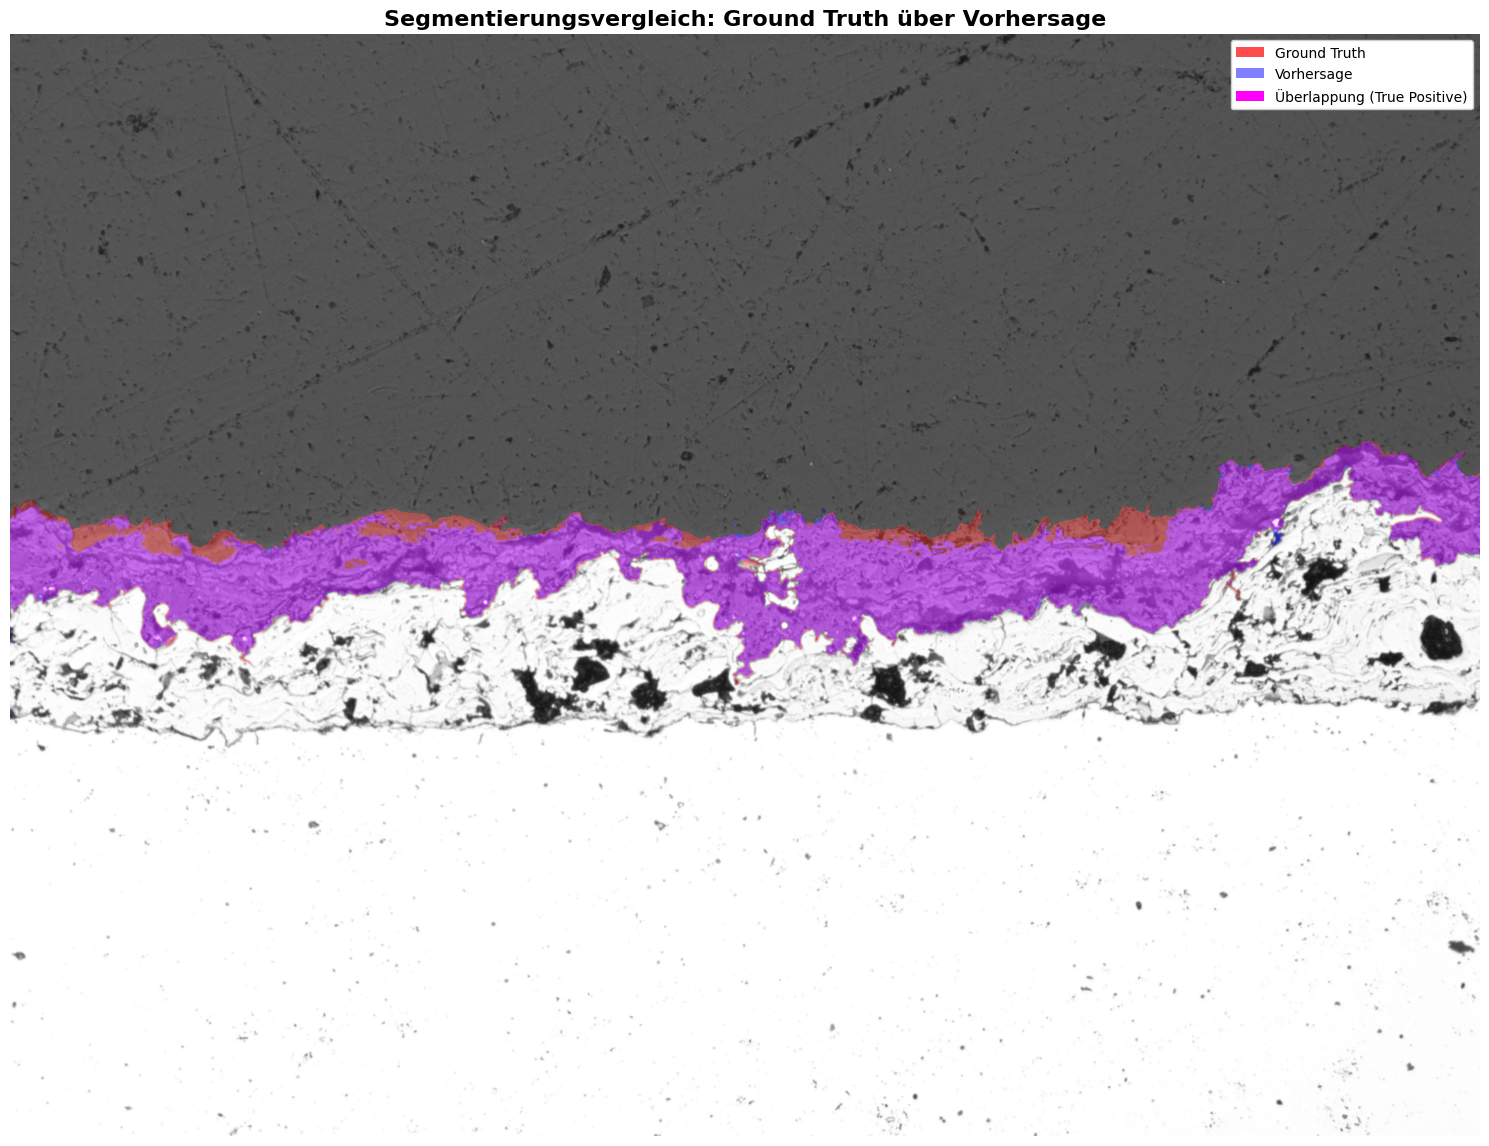

Quantitative Metriken:
   - IoU (Intersection over Union): 0.869
   - Dice Coefficient: 0.930
   - True Positives (Überlappung): 312,835 Pixel
   - False Negatives (nur GT): 44,991 Pixel
   - False Positives (nur Vorhersage): 2,113 Pixel
   - Überlappungsanteil: 86.9%


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage.transform import resize

def overlay_mask_tiff_correct_order(image_path, gt_mask_path, pred_mask_path, title="Vergleich", alpha=0.5):
    """
    Legt eine Vorhersagemaske transparent über ein Graustufen-TIFF-Bild und die Ground-Truth-Maske.
    KORREKTE REIHENFOLGE: Ground Truth wird über Vorhersage gelegt für sichtbare Überlappung.
    """

    # TIFF-Bilder laden
    image = io.imread(image_path)

    # Wenn das Bild Graustufen ist (2D), in RGB konvertieren
    if image.ndim == 2:
        image = np.stack([image] * 3, axis=-1)
    elif image.ndim == 3 and image.shape[2] > 3:
        image = image[:, :, :3]

    # Masken laden
    gt_mask = cv2.imread(gt_mask_path, cv2.IMREAD_GRAYSCALE)
    pred_mask = cv2.imread(pred_mask_path, cv2.IMREAD_GRAYSCALE)

    # Sicherstellen, dass die Masken die gleiche Größe wie das Bild haben
    if gt_mask.shape != image.shape[:2]:
        gt_mask = resize(gt_mask, image.shape[:2], order=0, preserve_range=True, anti_aliasing=False).astype(np.uint8)

    if pred_mask.shape != image.shape[:2]:
        pred_mask = resize(pred_mask, image.shape[:2], order=0, preserve_range=True, anti_aliasing=False).astype(np.uint8)

    # Sicherstellen, dass die Masken binär sind
    _, gt_mask_bin = cv2.threshold(gt_mask, 127, 255, cv2.THRESH_BINARY)
    _, pred_mask_bin = cv2.threshold(pred_mask, 127, 255, cv2.THRESH_BINARY)

    # Farben für die Überlagerung definieren
    gt_color = np.array([127, 0, 0])   # Rot [255, 0, 0] für GT
    pred_color = np.array([0, 0, 255]) # Blau [0, 0, 255] für Vorhersage

    # Vorhersage Maske zuerst einfügen (als Basis)
    pred_colored = np.zeros_like(image)
    pred_mask_indices = pred_mask_bin > 0
    for c in range(3):
        pred_colored[pred_mask_indices, c] = pred_color[c]

    # Ground Truth Maske darüberlegen (wichtig für sichtbare Überlappung!)
    gt_colored = np.zeros_like(image)
    gt_mask_indices = gt_mask_bin > 0
    for c in range(3):
        gt_colored[gt_mask_indices, c] = gt_color[c]

    # ÜBERLAGERUNG MIT KORREKTER REIHENFOLGE:
    # 1. Originalbild
    # 2. Vorhersage (Rot) mit mittlerer Transparenz
    # 3. Ground Truth (Blau) mit höherer Transparenz darüber
    overlay = cv2.addWeighted(image, 1.0, pred_colored, 0.5, 0)  # Vorhersage zuerst
    overlay = cv2.addWeighted(overlay, 1.0, gt_colored, 0.7, 0)   # GT darüber mit höherer Deckkraft

    # Plot erstellen
    plt.figure(figsize=(15, 12))
    plt.imshow(overlay)
    plt.title(title, fontsize=16, fontweight='bold')
    plt.axis('off')

    # Legende hinzufügen
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='red', alpha=0.7, label='Ground Truth'),
                       Patch(facecolor='blue', alpha=0.5, label='Vorhersage'),
                       Patch(facecolor='magenta', label='Überlappung (True Positive)')]
    plt.legend(handles=legend_elements, loc='upper right', framealpha=1.0)

    plt.tight_layout()
    plt.show()

    # Metriken berechnen und Überlappungs-Pixel zählen
    calculate_iou_dice_with_overlap(gt_mask_bin, pred_mask_bin)

def calculate_iou_dice_with_overlap(gt_mask, pred_mask):
    """Berechnet Metriken und zählt Überlappungspixel"""
    gt_bool = gt_mask > 127
    pred_bool = pred_mask > 127

    intersection = np.logical_and(gt_bool, pred_bool)
    union = np.logical_or(gt_bool, pred_bool)

    iou = np.sum(intersection) / np.sum(union) if np.sum(union) > 0 else 0
    dice = 2 * np.sum(intersection) / (np.sum(gt_bool) + np.sum(pred_bool)) if (np.sum(gt_bool) + np.sum(pred_bool)) > 0 else 0

    print("Quantitative Metriken:")
    print(f"   - IoU (Intersection over Union): {iou:.3f}")
    print(f"   - Dice Coefficient: {dice:.3f}")
    print(f"   - True Positives (Überlappung): {np.sum(intersection):,} Pixel")
    print(f"   - False Negatives (nur GT): {np.sum(gt_bool) - np.sum(intersection):,} Pixel")
    print(f"   - False Positives (nur Vorhersage): {np.sum(pred_bool) - np.sum(intersection):,} Pixel")
    print(f"   - Überlappungsanteil: {np.sum(intersection)/np.sum(union)*100:.1f}%")

# --- FÜR DIE NUTZUNG: Pfade anpassen und Funktion aufrufen ---
# HIER IHRE DATEIPFADE EINGEBEN:
original_image_path = "/content/drive/MyDrive/Colab Notebooks/Bachelor/test_data/images/2181_2_2 (1).tif"
ground_truth_mask_path = "/content/drive/MyDrive/Colab Notebooks/Bachelor/Plots/Plots_Von_08_09/Test/MY_HA/gt_mask/2181_2_2 (1)_gt.png" #2181_2_2 (1)_gt.png
prediction_mask_path = "/content/drive/MyDrive/Colab Notebooks/Bachelor/Plots/Plots_Von_08_09/Test/MY_HA/pred_masks/2181_2_2 (1)_pred.png" #2181_2_2 (1)_pred.png

# Überlagerung plotten (alpha steuert die Deckkraft der Vorhersage)
overlay_mask_tiff_correct_order(original_image_path, ground_truth_mask_path, prediction_mask_path,
                               title="Segmentierungsvergleich: Ground Truth über Vorhersage", alpha=0.5)

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from skimage import io
from skimage.transform import resize
from pathlib import Path
import csv

# Ordnerpfade

#---------------------
# MY_HA
#---------------------
IMG_DIR  = Path(r"/content/drive/MyDrive/Colab Notebooks/Bachelor/test_data/images")
GT_DIR   = Path(r"/content/drive/MyDrive/Colab Notebooks/Bachelor/Plots/Plots_Von_08_09/Test/SAM/gt_mask")
PRED_DIR = Path(r"/content/drive/MyDrive/Colab Notebooks/Bachelor/Plots/Plots_Von_08_09/Test/MY_HA/pred_masks")
OUT_DIR  = Path(r"/content/drive/MyDrive/Colab Notebooks/Bachelor/Plots/Plots_Von_08_09/Test/MY_HA/overlay_pred_gt_img")

"""
#---------------------
# SAM
#---------------------
IMG_DIR  = Path(r"/content/drive/MyDrive/Colab Notebooks/Bachelor/test_data/images")
GT_DIR   = Path(r"/content/drive/MyDrive/Colab Notebooks/Bachelor/Plots/Plots_Von_08_09/Test/SAM/gt_mask")
PRED_DIR = Path(r"/content/drive/MyDrive/Colab Notebooks/Bachelor/Plots/Plots_Von_08_09/Test/SAM/pred_masks")
OUT_DIR  = Path(r"/content/drive/MyDrive/Colab Notebooks/Bachelor/Plots/Plots_Von_08_09/Test/SAM/overlay_pred_gt_img")
"""
"""
#---------------------
# Otsu Threshold
#---------------------
IMG_DIR  = Path(r"/content/drive/MyDrive/Colab Notebooks/Bachelor/test_data/images")
GT_DIR   = Path(r"/content/drive/MyDrive/Colab Notebooks/Bachelor/Plots/Plots_Von_08_09/Test/SAM/gt_mask")
PRED_DIR = Path(r"/content/drive/MyDrive/Colab Notebooks/Bachelor/Plots/Plots_Von_08_09/Test/Otsu_Threshold/pred_masks")
OUT_DIR  = Path(r"/content/drive/MyDrive/Colab Notebooks/Bachelor/Plots/Plots_Von_08_09/Test/Otsu_Threshold/overlay_pred_gt_img")
"""

ALPHA_PRED = 0.5   # Deckkraft Vorhersage
ALPHA_GT   = 0.7   # Deckkraft Ground Truth

# Farben in RGB
COLOR_PRED = np.array([0, 0, 255], dtype=np.uint8)    # Blau
COLOR_GT   = np.array([255, 0, 0], dtype=np.uint8)    # Rot
COLOR_INT  = np.array([255, 0, 255], dtype=np.uint8)  # Magenta für Überlappung

# -----------------------------------------
# HILFSFUNKTIONEN
# -----------------------------------------
def to_uint8_rgb(img):
    """Sorgt dafür, dass das Bild RGB uint8 ist."""
    if img.ndim == 2:
        img = np.stack([img]*3, axis=-1)
    elif img.ndim == 3 and img.shape[2] > 3:
        img = img[:, :, :3]

    if img.dtype == np.uint8:
        return img

    img = img.astype(np.float32)
    if img.max() <= 1.0:  # vermutlich 0..1
        img = img * 255.0
    else:
        # robust normalisieren
        vmin, vmax = float(img.min()), float(img.max())
        if vmax > vmin:
            img = (img - vmin) / (vmax - vmin) * 255.0
        else:
            img = np.zeros_like(img)  # konstantes Bild
    return img.clip(0, 255).astype(np.uint8)

def load_mask_bin(path, target_shape):
    """Graustufenmaske laden, auf Bildgröße bringen, binär 0/255 ausgeben."""
    m = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    if m is None:
        raise FileNotFoundError(f"Maske nicht gefunden: {path}")
    if m.shape != target_shape[:2]:
        m = resize(m, target_shape[:2], order=0, preserve_range=True, anti_aliasing=False).astype(np.uint8)
    _, m_bin = cv2.threshold(m, 127, 255, cv2.THRESH_BINARY)
    return m_bin

def make_overlay(image_rgb_u8, gt_bin, pred_bin, alpha_pred=0.5, alpha_gt=0.7):
    """Erzeugt Overlay: Bild + Pred (blau) + GT (rot) + Schnittmenge (magenta)."""
    pred_layer = np.zeros_like(image_rgb_u8, dtype=np.uint8)
    gt_layer   = np.zeros_like(image_rgb_u8, dtype=np.uint8)
    int_layer  = np.zeros_like(image_rgb_u8, dtype=np.uint8)

    pred_idx = pred_bin > 0
    gt_idx   = gt_bin > 0
    int_idx  = np.logical_and(pred_idx, gt_idx)

    for c in range(3):
        pred_layer[pred_idx, c] = COLOR_PRED[c]
        gt_layer[gt_idx, c]     = COLOR_GT[c]
        int_layer[int_idx, c]   = COLOR_INT[c]

    out = cv2.addWeighted(image_rgb_u8, 1.0, pred_layer, alpha_pred, 0)
    out = cv2.addWeighted(out, 1.0, gt_layer, alpha_gt, 0)
    # Schnittmenge oben drauf, etwas kräftiger
    out = cv2.addWeighted(out, 1.0, int_layer, 0.8, 0)
    return out

def metrics(gt_bin, pred_bin):
    """IoU, Dice, Zählwerte."""
    gt_bool = gt_bin > 0
    pr_bool = pred_bin > 0
    inter   = np.logical_and(gt_bool, pr_bool)
    union   = np.logical_or(gt_bool, pr_bool)

    tp = int(inter.sum())
    fn = int((gt_bool & ~pr_bool).sum())
    fp = int((pr_bool & ~gt_bool).sum())
    u  = int(union.sum())
    g  = int(gt_bool.sum())
    p  = int(pr_bool.sum())

    iou  = (tp / u) if u > 0 else 0.0
    dice = (2*tp / (g + p)) if (g + p) > 0 else 0.0
    overlap_pct = (tp / u * 100.0) if u > 0 else 0.0
    return {
        "IoU": round(iou, 6),
        "Dice": round(dice, 6),
        "TP": tp,
        "FN": fn,
        "FP": fp,
        "Union_px": u,
        "GT_px": g,
        "Pred_px": p,
        "Overlap_pct": round(overlap_pct, 3),
    }

def save_overlay_png(img_rgb_u8, stem, out_dir, iou=None, dice=None):
    """Speichert eine PNG mit einfacher Legende."""
    plt.figure(figsize=(10, 8))
    plt.imshow(img_rgb_u8)
    title = stem
    if iou is not None and dice is not None:
        title += f"  |  IoU {iou:.3f}  •  Dice {dice:.3f}"
    plt.title(title)
    plt.axis('off')

    legend = [
        Patch(facecolor=(COLOR_PRED/255), label='Vorhersage', alpha=ALPHA_PRED),
        Patch(facecolor=(COLOR_GT/255),   label='Ground Truth', alpha=ALPHA_GT),
        Patch(facecolor=(COLOR_INT/255),  label='Überlappung', alpha=0.8),
    ]
    plt.legend(handles=legend, loc='upper right', framealpha=1.0)
    out_path = out_dir / f"{stem}_overlay.png"
    plt.tight_layout()
    plt.savefig(out_path, dpi=200)
    plt.close()
    return out_path

# -----------------------------------------
# LAUF
# -----------------------------------------
OUT_DIR.mkdir(parents=True, exist_ok=True)
summary_rows = []

tif_files = sorted(IMG_DIR.glob("*.tif"))
if not tif_files:
    print(f"Keine .tif in {IMG_DIR}")

for tif_path in tif_files:
    stem = tif_path.stem  # z. B. "2181_2_2 (1)"
    gt_path   = GT_DIR  / f"{stem}_gt.png"
    pred_path = PRED_DIR/ f"{stem}_pred.png"

    missing = [p for p in [tif_path, gt_path, pred_path] if not p.exists()]
    if missing:
        print(f"Übersprungen: {stem}  (fehlt: {', '.join([m.name for m in missing])})")
        continue

    # Bild laden und vorbereiten
    img = io.imread(str(tif_path))
    img = to_uint8_rgb(img)

    # Masken laden
    gt_bin   = load_mask_bin(gt_path, img.shape)
    pred_bin = load_mask_bin(pred_path, img.shape)

    # Overlay und Metriken
    ov = make_overlay(img, gt_bin, pred_bin, ALPHA_PRED, ALPHA_GT)
    m  = metrics(gt_bin, pred_bin)

    out_png = save_overlay_png(ov, stem, OUT_DIR, iou=m["IoU"], dice=m["Dice"])

    # Konsole
    print(f"{stem}: IoU {m['IoU']:.3f} | Dice {m['Dice']:.3f}  →  {out_png.name}")

    # Zusammenfassung sammeln
    summary_rows.append({
        "stem": stem,
        "image_path": str(tif_path),
        "gt_path": str(gt_path),
        "pred_path": str(pred_path),
        "overlay_png": str(out_png),
        **m
    })

# CSV schreiben
summary_csv = OUT_DIR / "metrics_summary.csv"
with open(summary_csv, "w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=list(summary_rows[0].keys()) if summary_rows else ["stem"])
    writer.writeheader()
    for r in summary_rows:
        writer.writerow(r)

print(f"\nFertig. Overlays und Metriken hier: {OUT_DIR}")
print(f"CSV: {summary_csv}")

2181_1_1 (4): IoU 0.881 | Dice 0.937  →  2181_1_1 (4)_overlay.png
2181_1_2 (3): IoU 0.927 | Dice 0.962  →  2181_1_2 (3)_overlay.png
2181_1_2 (5): IoU 0.885 | Dice 0.939  →  2181_1_2 (5)_overlay.png
2181_2_2 (1): IoU 0.869 | Dice 0.930  →  2181_2_2 (1)_overlay.png
2181_2_2 (3): IoU 0.805 | Dice 0.892  →  2181_2_2 (3)_overlay.png
2181_2_3 (1): IoU 0.894 | Dice 0.944  →  2181_2_3 (1)_overlay.png
2181_3_1 (1): IoU 0.868 | Dice 0.929  →  2181_3_1 (1)_overlay.png
2303_01 (6): IoU 0.897 | Dice 0.946  →  2303_01 (6)_overlay.png
2303_01 (9): IoU 0.720 | Dice 0.837  →  2303_01 (9)_overlay.png
2303_02 (2): IoU 0.942 | Dice 0.970  →  2303_02 (2)_overlay.png
2303_02 (4): IoU 0.926 | Dice 0.962  →  2303_02 (4)_overlay.png
2303_03 (2): IoU 0.942 | Dice 0.970  →  2303_03 (2)_overlay.png
2303_04 (1): IoU 0.897 | Dice 0.946  →  2303_04 (1)_overlay.png
2303_09 (1): IoU 0.955 | Dice 0.977  →  2303_09 (1)_overlay.png
2303_09 (4): IoU 0.850 | Dice 0.919  →  2303_09 (4)_overlay.png
2303_11 (2): IoU 0.966 | D